### create a dataset 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

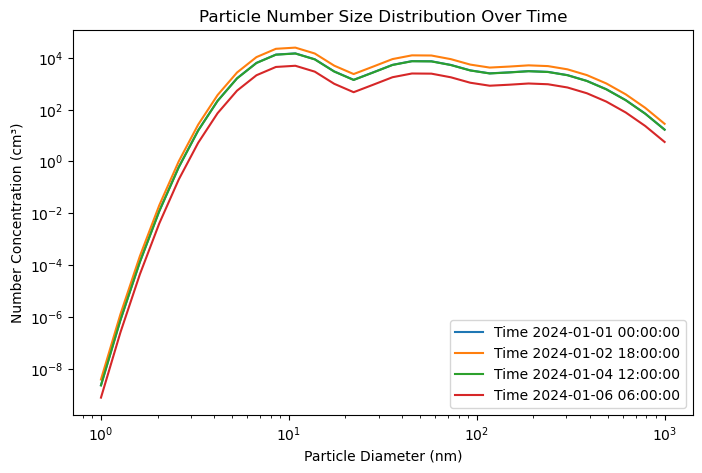

In [6]:
# Parameters
num_bins = 30  # Number of size bins
num_timesteps = 24*7  # (e.g., hourly data for 7 days)
time_index = pd.date_range(start="2024-01-01", periods=num_timesteps, freq="H")

# Generate logarithmically spaced size bins (Diameter in nm)
size_bins = np.logspace(np.log10(1), np.log10(1000), num_bins)

# Simulating Particle Number Size Distribution (PNSD)
# Using Gaussian distributions to represent nucleation, Aitken, and accumulation modes
def particle_distribution(size_bins, mode, sigma, peak_concentration):
    return peak_concentration * np.exp(-((np.log(size_bins) - np.log(mode))**2) / (2 * sigma**2))

# Define three modes
modes = [
    {"mode": 10, "sigma": 0.3, "peak": 10000},  # Nucleation mode
    {"mode": 50, "sigma": 0.4, "peak": 5000},   # Aitken mode
    {"mode": 200, "sigma": 0.5, "peak": 2000},  # Accumulation mode
]

# Compute base PNSD
base_pnsd = np.zeros((num_timesteps, num_bins))
for mode in modes:
    base_pnsd += particle_distribution(size_bins, mode["mode"], mode["sigma"], mode["peak"])

# Introduce diurnal variation
diurnal_variation = np.sin(np.linspace(0, 2 * np.pi, num_timesteps)) + 1.5  # Variation factor
pnsd_time_series = base_pnsd * diurnal_variation[:, np.newaxis]

# Create DataFrame
df_pnsd = pd.DataFrame(pnsd_time_series, columns=[f"{int(size)} nm" for size in size_bins], index=time_index)

# Plot example distribution at different time steps
plt.figure(figsize=(8, 5))
for t in range(0, num_timesteps, num_timesteps // 4):  # Plot 4 snapshots
    plt.plot(size_bins, pnsd_time_series[t, :], label=f'Time {df_pnsd.index[t]}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Particle Diameter (nm)")
plt.ylabel("Number Concentration (cm³)")
plt.title("Particle Number Size Distribution Over Time")
plt.legend()
plt.show()


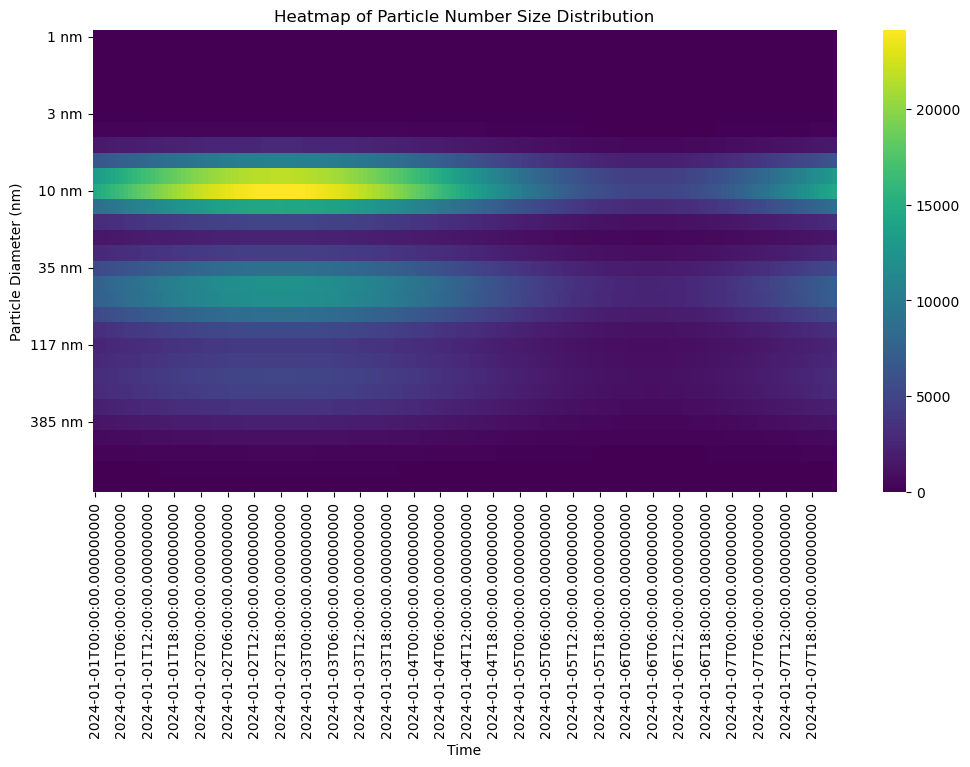

In [7]:
# Plot heatmap of PNSD
plt.figure(figsize=(12, 6))
sns.heatmap(df_pnsd.T, cmap="viridis", cbar=True, xticklabels=6, yticklabels=5)

plt.xlabel("Time")
plt.ylabel("Particle Diameter (nm)")
plt.title("Heatmap of Particle Number Size Distribution")
plt.yticks(rotation=0)  # Keep size bin labels readable
plt.show()


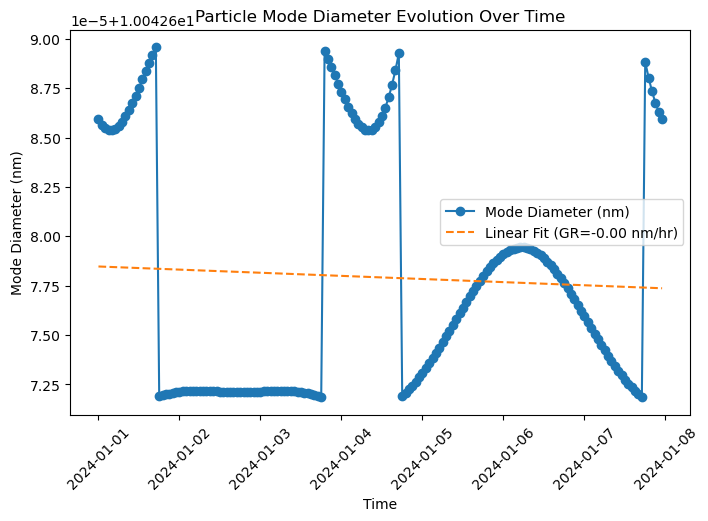

-6.604501925741007e-09

In [8]:
# Define lognormal distribution function for fitting
def lognormal(x, N, mu, sigma):
    return N * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))

# Extract mode diameter (Dp_mode) over time
mode_diameters = []

for t in range(num_timesteps):
    y_data = pnsd_time_series[t, :]
    
    # Fit lognormal distribution to the data
    try:
        popt, _ = curve_fit(lognormal, size_bins, y_data, p0=[1e4, np.log(10), 0.5], maxfev=10000)
        mode_diameter = np.exp(popt[1])  # Convert log(mu) back to linear scale
    except RuntimeError:
        mode_diameter = np.nan  # In case of fitting failure

    mode_diameters.append(mode_diameter)

# Convert to DataFrame
df_growth = pd.DataFrame({
    "Time": time_index,
    "Mode_Diameter_nm": mode_diameters
})

# Drop NaN values (if any)
df_growth = df_growth.dropna()

# Fit a linear model to estimate growth rate (GR = dDp/dt)
time_numeric = (df_growth["Time"] - df_growth["Time"].iloc[0]).dt.total_seconds() / 3600  # Convert time to hours
coeffs = np.polyfit(time_numeric, df_growth["Mode_Diameter_nm"], 1)  # Linear fit
growth_rate_nm_hr = coeffs[0]  # Slope represents GR in nm/hr


# Plot mode diameter evolution over time
plt.figure(figsize=(8, 5))
plt.plot(df_growth["Time"], df_growth["Mode_Diameter_nm"], 'o-', label="Mode Diameter (nm)")
plt.plot(df_growth["Time"], coeffs[0] * time_numeric + coeffs[1], '--', label=f"Linear Fit (GR={growth_rate_nm_hr:.2f} nm/hr)")

plt.xlabel("Time")
plt.ylabel("Mode Diameter (nm)")
plt.title("Particle Mode Diameter Evolution Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Return estimated growth rate
growth_rate_nm_hr


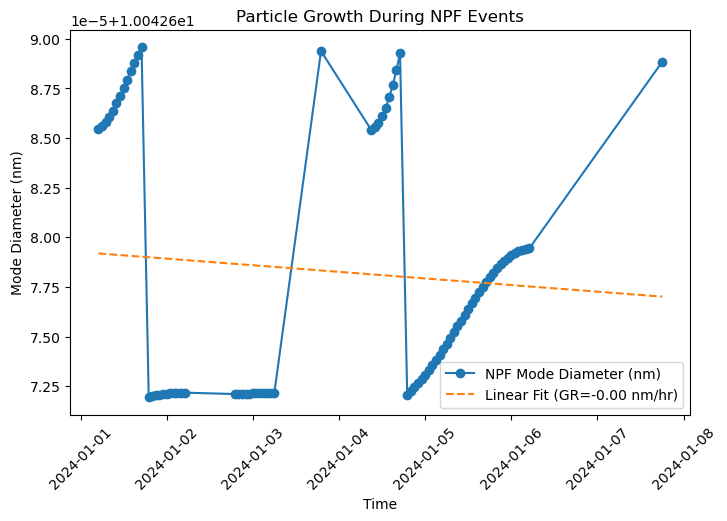

-1.386140250315951e-08

In [9]:
# Define an NPF threshold for mode diameter (e.g., starts below 30 nm and increases)
npf_threshold = 30  # nm
npf_growth_periods = df_growth[df_growth["Mode_Diameter_nm"] < npf_threshold]

# Ensure mode diameter is increasing
npf_growth_periods = npf_growth_periods[npf_growth_periods["Mode_Diameter_nm"].diff() > 0]

# Convert time to numeric (hours from start)
time_numeric_npf = (npf_growth_periods["Time"] - npf_growth_periods["Time"].iloc[0]).dt.total_seconds() / 3600

# Fit a linear model to estimate the growth rate during NPF events
if len(npf_growth_periods) > 1:
    coeffs_npf = np.polyfit(time_numeric_npf, npf_growth_periods["Mode_Diameter_nm"], 1)
    growth_rate_npf_nm_hr = coeffs_npf[0]  # Slope represents GR in nm/hr
else:
    growth_rate_npf_nm_hr = np.nan  # Not enough data points


# Plot mode diameter evolution during NPF
plt.figure(figsize=(8, 5))
plt.plot(npf_growth_periods["Time"], npf_growth_periods["Mode_Diameter_nm"], 'o-', label="NPF Mode Diameter (nm)")
if len(npf_growth_periods) > 1:
    plt.plot(npf_growth_periods["Time"], coeffs_npf[0] * time_numeric_npf + coeffs_npf[1], '--', label=f"Linear Fit (GR={growth_rate_npf_nm_hr:.2f} nm/hr)")

plt.xlabel("Time")
plt.ylabel("Mode Diameter (nm)")
plt.title("Particle Growth During NPF Events")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Return the estimated growth rate during NPF
growth_rate_npf_nm_hr


In [10]:
# Group NPF event periods by continuous time blocks
npf_growth_periods["Time_Diff"] = npf_growth_periods["Time"].diff().dt.total_seconds() / 3600  # Time difference in hours
npf_growth_periods["Event_ID"] = (npf_growth_periods["Time_Diff"] > 2).cumsum()  # New event if gap > 2 hours

# Store growth rates for each NPF event separately
growth_rates_per_event = []

for event_id, group in npf_growth_periods.groupby("Event_ID"):
    if len(group) > 1:
        time_numeric_event = (group["Time"] - group["Time"].iloc[0]).dt.total_seconds() / 3600
        coeffs_event = np.polyfit(time_numeric_event, group["Mode_Diameter_nm"], 1)
        growth_rate_event = coeffs_event[0]  # nm/hr
        growth_rates_per_event.append([group["Time"].iloc[0], group["Time"].iloc[-1], growth_rate_event])

# Create DataFrame
df_growth_rates = pd.DataFrame(growth_rates_per_event, columns=["Start_Time", "End_Time", "Growth_Rate_nm_hr"])

# Return the table of growth rates
df_growth_rates


,Start_Time,End_Time,Growth_Rate_nm_hr
0,2024-01-01 05:00:00,2024-01-02 05:00:00,-8.523717e-07
1,2024-01-02 19:00:00,2024-01-03 06:00:00,7.255256e-09
2,2024-01-04 09:00:00,2024-01-06 05:00:00,-1.168508e-07
